In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import utils as ut
import model
import csv

Using TensorFlow backend.


In [2]:
# ===========================================
#        Parse the argument
# ===========================================
import argparse
parser = argparse.ArgumentParser()
# set up training configuration.
parser.add_argument('--gpu', default='', type=str)
parser.add_argument('--resume', default='weights.h5', type=str)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--data_path', default='/media/weidi/2TB-2/datasets/voxceleb1/wav', type=str)
# set up network configuration.
parser.add_argument('--net', default='resnet34s', choices=['resnet34s', 'resnet34l'], type=str)
parser.add_argument('--ghost_cluster', default=2, type=int)
parser.add_argument('--vlad_cluster', default=8, type=int)
parser.add_argument('--bottleneck_dim', default=512, type=int)
parser.add_argument('--aggregation_mode', default='gvlad', choices=['avg', 'vlad', 'gvlad'], type=str)
# set up learning rate, training loss and optimizer.
parser.add_argument('--loss', default='softmax', choices=['softmax', 'amsoftmax'], type=str)
parser.add_argument('--test_type', default='normal', choices=['normal', 'hard', 'extend'], type=str)

global args
args = parser.parse_args(args=[])

In [3]:
def predict_split(file, args=None):
    
    unique_list = [file]
    
    params = {'dim': (257, None, 1),
          'nfft': 512,
          'spec_len': 250,
          'win_length': 400,
          'hop_length': 160,
          'n_classes': 5994,
          'sampling_rate': 16000,
          'normalize': True,
          }
    
    network_eval = model.vggvox_resnet2d_icassp(input_dim=params['dim'],
                                            num_class=params['n_classes'],
                                            mode='eval', args=args)
    if args.resume:
        # ==> get real_model from arguments input,
        # load the model if the imag_model == real_model.
        if os.path.isfile(args.resume):
            network_eval.load_weights(os.path.join(args.resume), by_name=True)
            #result_path = set_result_path(args)
            #print('==> successfully loading model {}.'.format(args.resume))
        else:
            raise IOError("==> no checkpoint found at '{}'".format(args.resume))
    else:
        raise IOError('==> please type in the model to load')

    #print('==> start testing.')
    
    feats = []
    specs = ut.load_data(unique_list[0], win_length=params['win_length'], sr=params['sampling_rate'],
                         hop_length=params['hop_length'], n_fft=params['nfft'],
                         spec_len=params['spec_len'], mode='eval')
    specs = np.expand_dims(np.expand_dims(specs, 0), -1)

    v = network_eval.predict(specs)
    feats += [v]
    feats = np.array(feats)
    
    return feats

In [4]:
def get_speaker_names(ind):
    # ind is an array of speaker indexes
    
    ids = []
    names = []

    for i in ind:

        lookup = ' ' + str(i)

        # search for id in VoxCeleb2 from feats index
        with open('voxlb2_train.txt') as myFile:
            for line in myFile:
                if lookup in line:
                    clip = line
                    break
        id = 'n0' + clip[2:7]
        ids.append(id)

    for id in ids:

        with open('identity_meta.csv', 'rt') as f:
            reader = csv.reader(f, delimiter=',')
            for row in reader:
                if id == row[0]:
                    name = row[1].replace('_', ' ')
                    name = name.replace('"', '')
                    names.append(name[1:])
    return names

In [5]:
file = 'z-c-feisty.wav'
filename = os.path.splitext(os.path.basename(file))[0]
x, sr = librosa.load(file)

In [6]:
df = pd.DataFrame({"Time":np.arange(x.shape[0])/sr,"Amplitude":x})

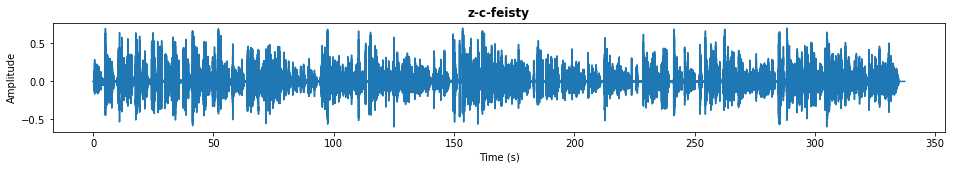

In [7]:
fig,ax = plt.subplots(figsize=(16, 2),nrows=1)
ax.plot(df['Time'], df['Amplitude']);
plt.xlabel('Time (s)');
plt.ylabel('Amplitude');
plt.title(filename, fontweight='bold');

In [8]:
split_seconds = 3
num_segments = np.floor(df['Time'].max()/split_seconds)

loop:  0
loop:  1
loop:  2


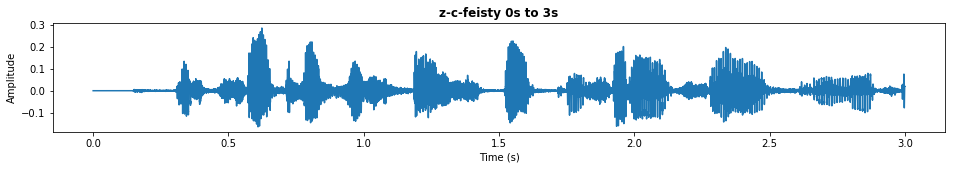

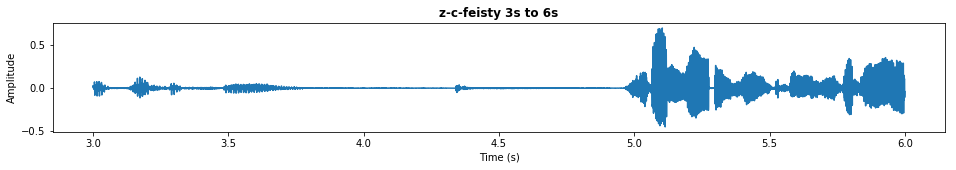

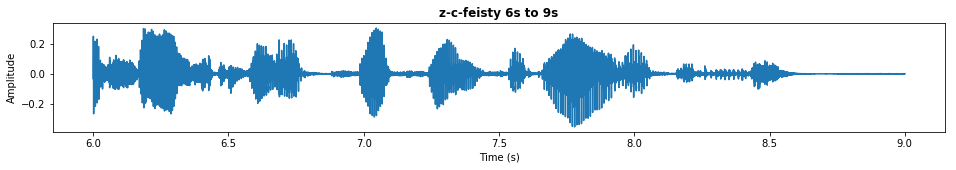

In [10]:
df_out = pd.DataFrame([])
t = 0
dt = 3  # how often to split audio file for predicting
plot = True

for i in range(3): # instead of 3, use num_segments
    print('loop: ', i)
    df_tmp = df.copy()
    df_tmp = df_tmp[(df_tmp['Time'] >= t) & (df_tmp['Time'] < (t+dt))]
    
    if plot:
        fig,ax = plt.subplots(figsize=(16, 2),nrows=1)
        ax.plot(df_tmp['Time'], df_tmp['Amplitude']);
        plt.xlabel('Time (s)');
        plt.ylabel('Amplitude');
        title = filename + ' ' + str(t) + 's to ' + str(t+dt) + 's'
        plt.title(title, fontweight='bold');
    
    amp = np.array(df_tmp['Amplitude'])
    librosa.output.write_wav('trimmed_tmp.wav', amp, sr)
    
    feats = predict_split('trimmed_tmp.wav', args)
    
    # find top 5
    feats = feats.reshape(5994)
    ind = feats.argsort()[-5:][::-1]
    
    names = get_speaker_names(ind)
    
    df_out = df_out.append(pd.DataFrame({'Time (s)': t+dt,
                                         'Speaker 1': names[0],
                                         'Speaker 2': names[1], 
                                         'Speaker 3': names[2],
                                         'Speaker 4': names[3],
                                         'Speaker 5': names[4]}, index=[0]), ignore_index=True)
    os.remove('trimmed_tmp.wav')
    
    t += dt

In [11]:
df_out

,Time (s),Speaker 1,Speaker 2,Speaker 3,Speaker 4,Speaker 5
0,3,Michelle Rodriguez,Katie Couric,Amanda Righetti,Ralf Rangnick,Phyllis Logan
1,6,Cory Jane,Konstantinos Mitroglou,Lindsay Whalen,Edward Norton,Tishani Doshi
2,9,Preetika Rao,Josef Ackermann,Anthony Davis,Chuck Scarborough,Tracy-Ann Oberman
